In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

In [2]:
# Displaying routine

def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

In [3]:
# Set random seeds

torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [4]:
# Define data loading step

batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [5]:
# Defining the device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [27]:
# Defining the model

d = 20

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),
            nn.Sigmoid(), # limit output to 0-1
        )

    def reparameterise(self, mu, logvar):
        if self.training: # if we are training use reparametrisation
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_() # sample from a normal distribution
            # std.size() gets the size of the std, then std.new_empty creates a new tensor with this size
            # normal_() fill it with values sampled from a N(0,I)
            return eps.mul_(std).add_(mu) # formula mean + std*epsilon
            # by calling this in a for loop we get the cloud of points
            # for each input we get a bubble with mean mu and radius std and we have randomness to the points we get from eps
        else:
            # best value the encoder can give me
            return mu # if we are not training there is no need to add noise (nn is used deterministically)

    def forward(self, x):
        # see breakdown of code below
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, d) # (batch_size, 2, d) tensor of means and stds
        mu = mu_logvar[:, 0, :] # (batch_size, d) vector of means
        logvar = mu_logvar[:, 1, :] # (batch_size, d) vector of stds
        # given the variances are only positive by computing the log we output the full real range for the encoder
        z = self.reparameterise(mu, logvar) # LATENT VARIABLE: sampling from distribution (mu,logvar) with normal noise
        return self.decoder(z), mu, logvar # decoding step

model = VAE().to(device)

In [8]:
xb, yb = next(iter(train_loader))
xb.shape, yb.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

In [9]:
xb_to_encoder = xb.view(-1, 784); xb_to_encoder.shape

torch.Size([256, 784])

In [10]:
d = 20
encoder = nn.Sequential(
    nn.Linear(784, d ** 2),
    nn.ReLU(),
    nn.Linear(d ** 2, d * 2)
)

In [14]:
encoder_out = encoder(xb_to_encoder)
# split the output of the encoder into two vectors where one will represent the means and the other the variances
encoder_out.shape, encoder_out.view(-1,2,d).shape

(torch.Size([256, 40]), torch.Size([256, 2, 20]))

In [15]:
encoder_out_mu = encoder_out.view(-1,2,d)
mu_encoder = encoder_out_mu[:,0,:]
logvar_encoder = encoder_out_mu[:,1,:]
mu_encoder.shape, logvar_encoder.shape # means and variances from which to sample from

(torch.Size([256, 20]), torch.Size([256, 20]))

In [22]:
# during training phase:
std = logvar_encoder.mul(0.5).exp_() # (batch_size, d)
eps = std.new_empty(std.size()).normal_() # sample from a normal distribution (batch_size, d)
z = eps.mul_(std).add_(mu_encoder)
z.shape # (batch_size, d)

torch.Size([256, 20])

In [24]:
decoder = nn.Sequential(
    nn.Linear(d, d ** 2),
    nn.ReLU(),
    nn.Linear(d ** 2, 784),
    nn.Sigmoid(), # limit output to 0-1
)

In [26]:
output = decoder(z)
output.shape

torch.Size([256, 784])

In [28]:
# Setting the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [29]:
# Reconstruction + β * KL divergence losses summed over all elements and batch

def loss_function(x_hat, x, mu, logvar, β=1):
    # binary cross entropy between input and reconstruction
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + β * KLD

====> Test set loss: 543.4080
====> Epoch: 1 Average loss: 187.5247
====> Test set loss: 134.3979
====> Epoch: 2 Average loss: 131.7991
====> Test set loss: 115.1702
====> Epoch: 3 Average loss: 120.5267
====> Test set loss: 108.5047
====> Epoch: 4 Average loss: 115.6552
====> Test set loss: 104.7256
====> Epoch: 5 Average loss: 112.8603
====> Test set loss: 102.3153
====> Epoch: 6 Average loss: 111.2324
====> Test set loss: 100.8216
====> Epoch: 7 Average loss: 109.9356
====> Test set loss: 100.9418
====> Epoch: 8 Average loss: 109.0198
====> Test set loss: 99.9148
====> Epoch: 9 Average loss: 108.2674
====> Test set loss: 98.3626
====> Epoch: 10 Average loss: 107.6591
====> Test set loss: 98.1429


C:\Users\miguelfarinha\AppData\Local\Temp\ipykernel_10636\1987914412.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(18, 4))


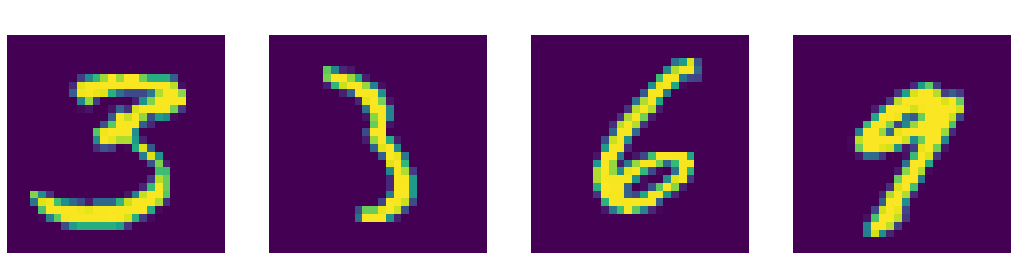

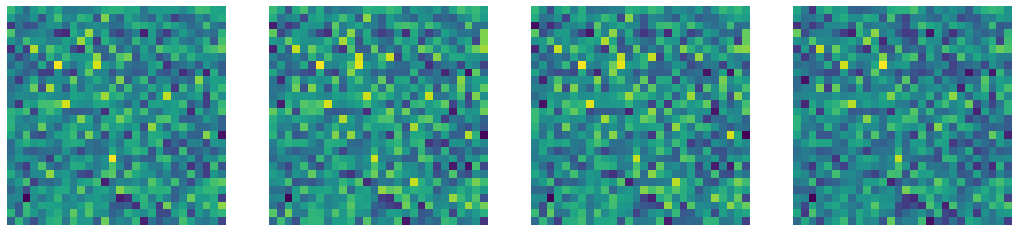

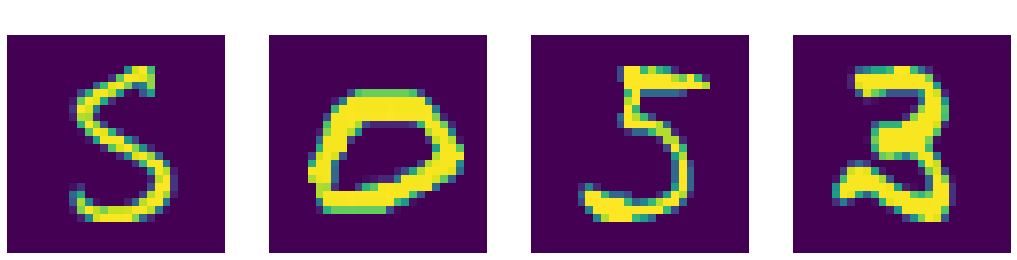

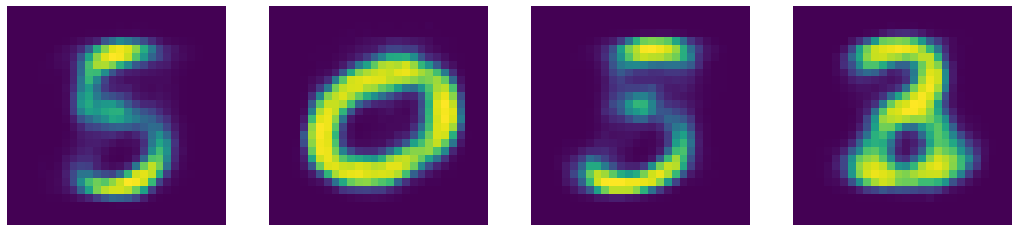

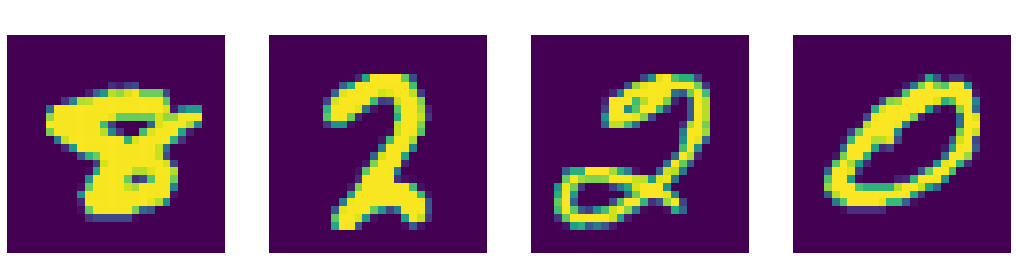

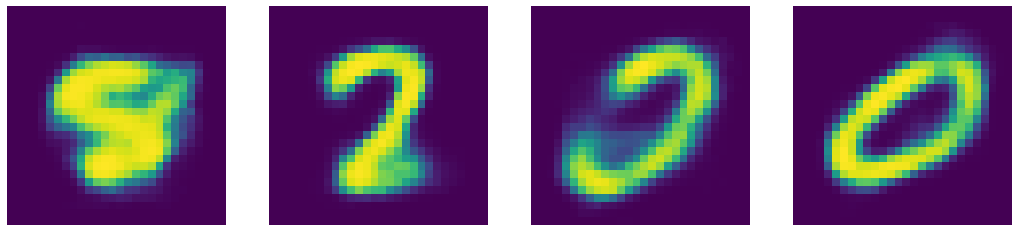

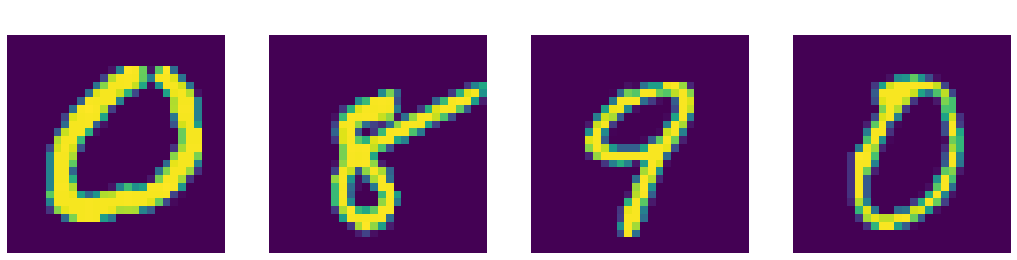

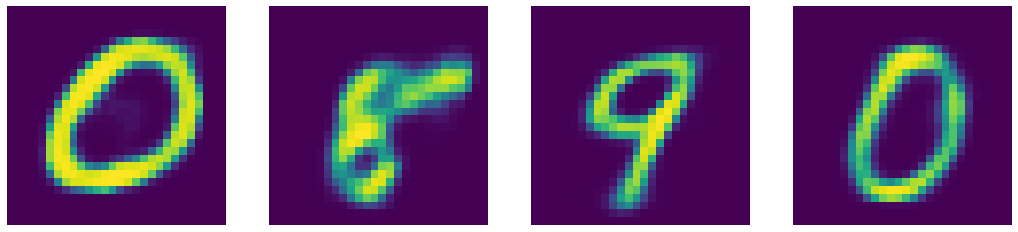

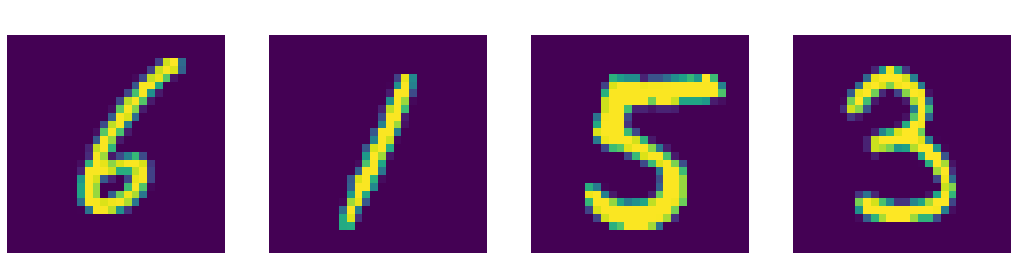

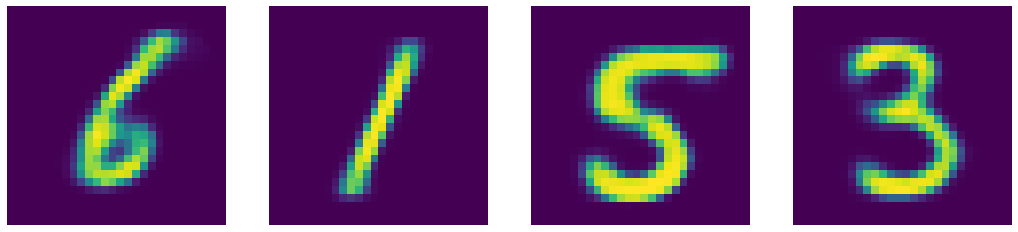

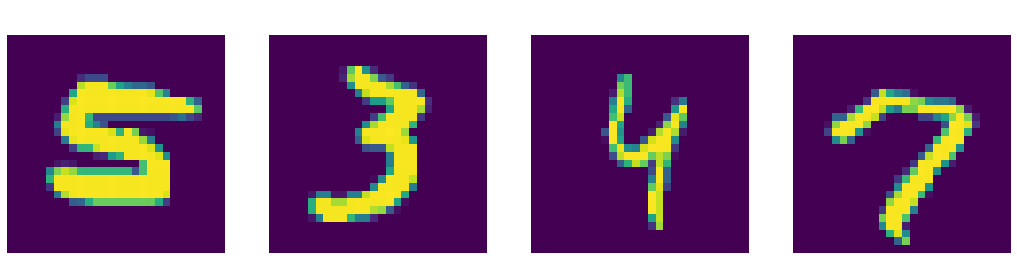

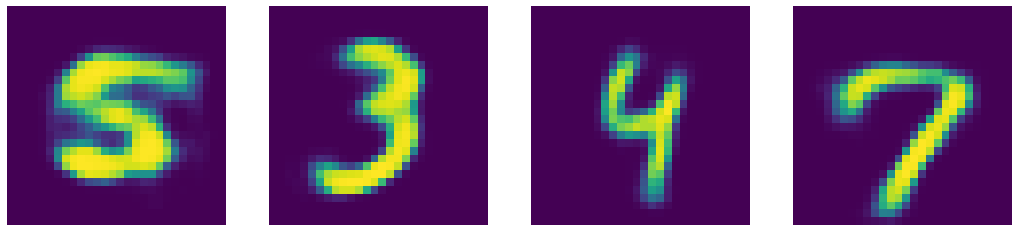

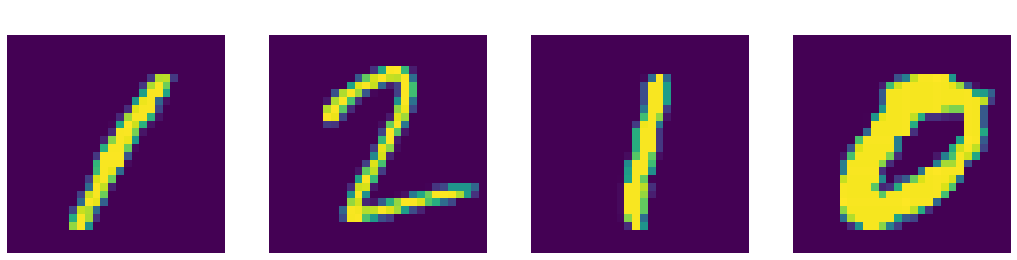

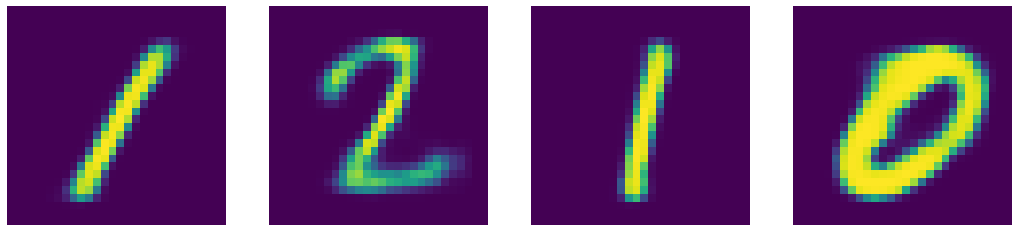

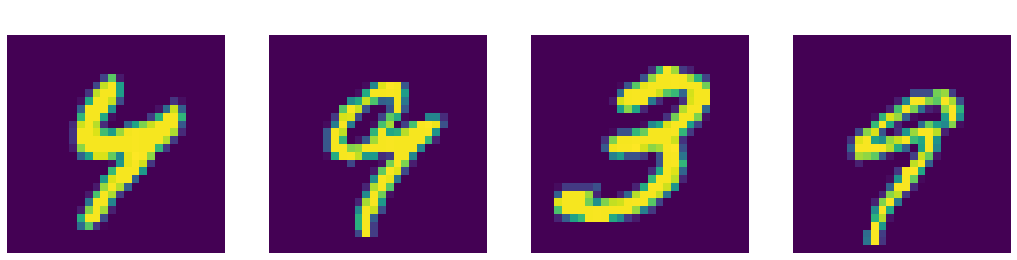

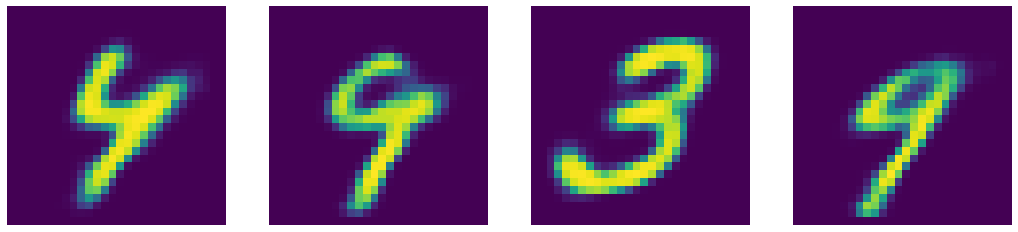

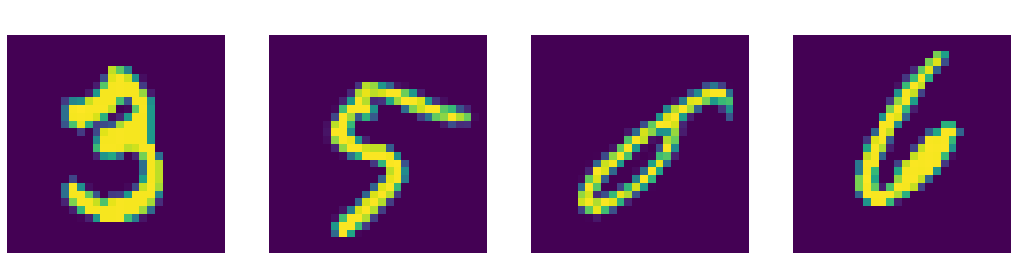

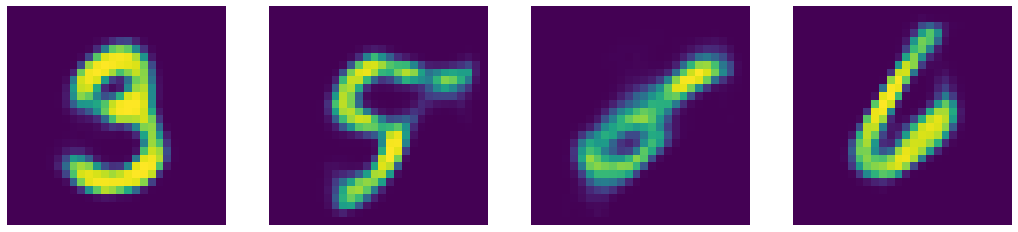

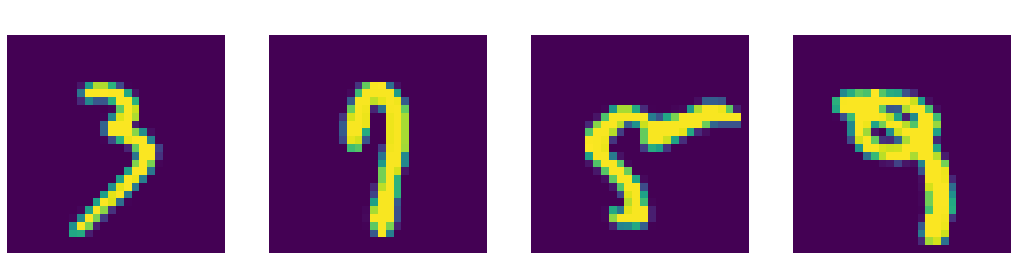

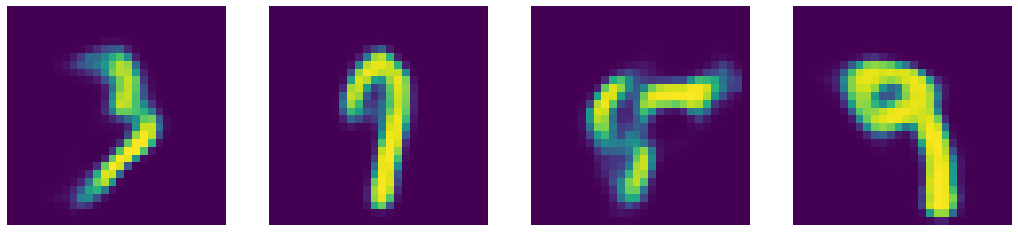

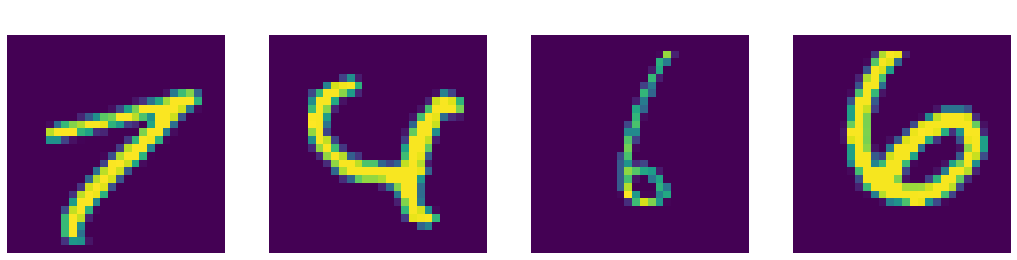

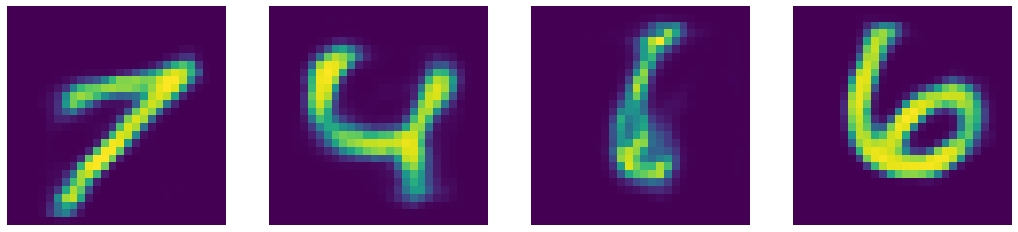

In [32]:
# Training and testing the VAE

epochs = 10
codes = dict(μ=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing
    
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 1, f'Epoch {epoch}')

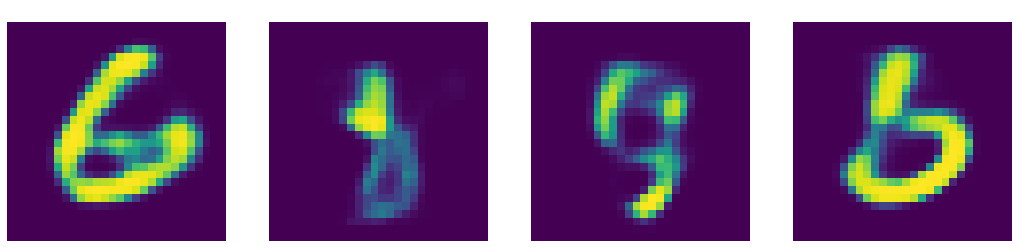

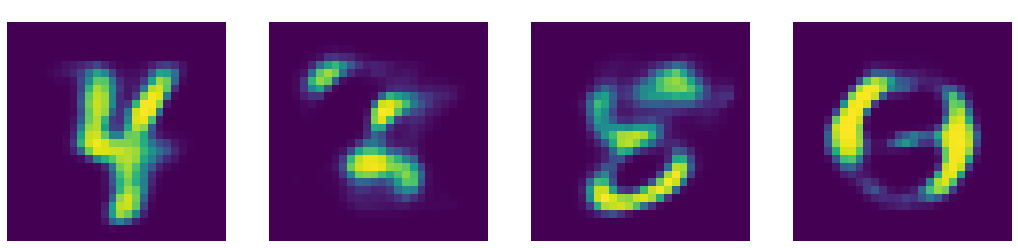

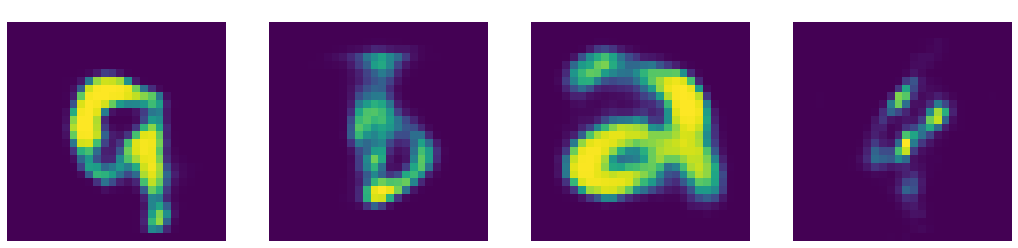

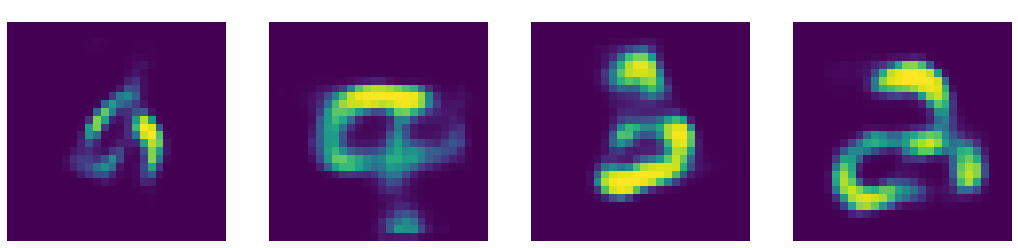

In [33]:
# Generating a few samples

N = 16
z = torch.randn((N, d)).to(device)
sample = model.decoder(z) # sampling from the distribution that the latent variable should have followed, i.e., N(0,I)
display_images(None, sample, N // 4, count=True)
# We didn't train as much as we should

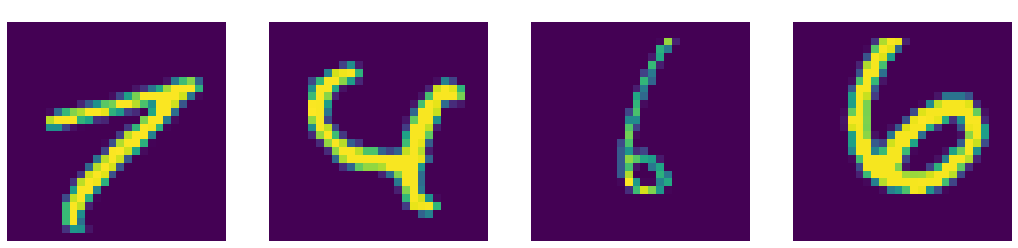

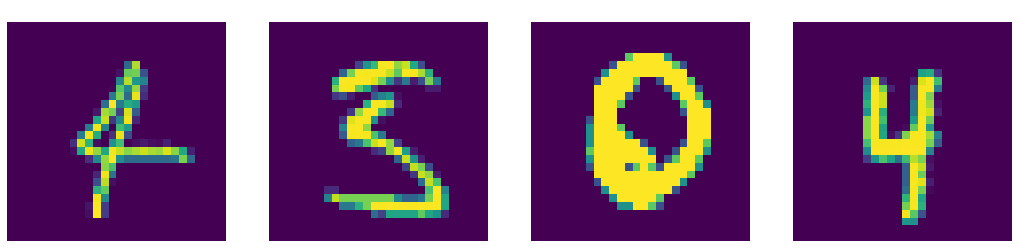

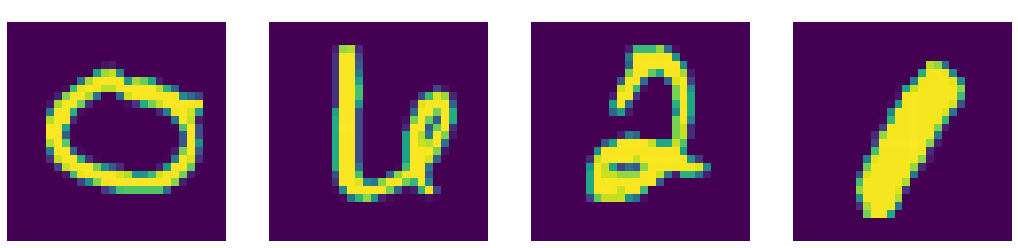

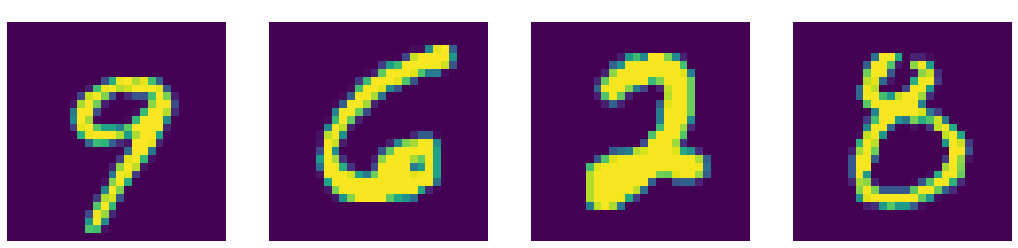

In [34]:
# Display last test batch

display_images(None, x, 4, count=True)

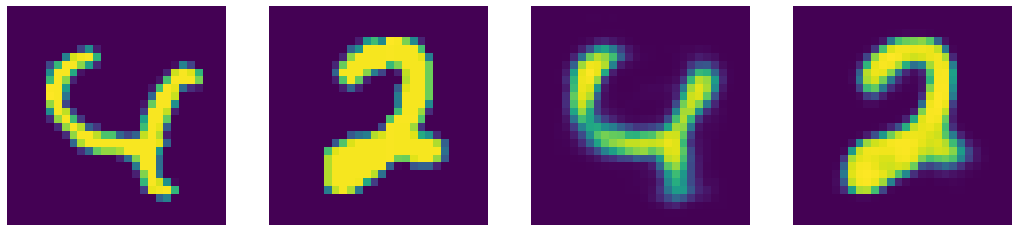

In [35]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed

A, B = 1, 14
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1),
    sample.data[0],
    sample.data[1]
)), 0))

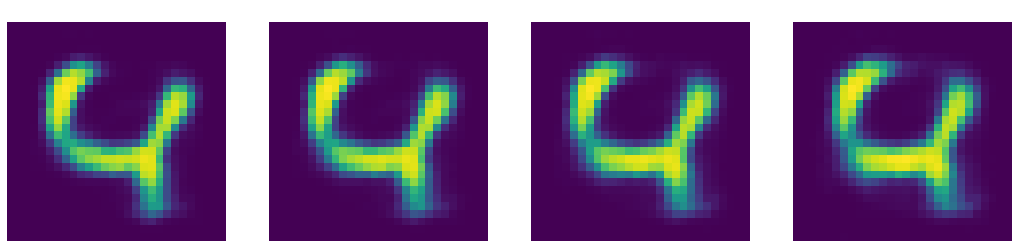

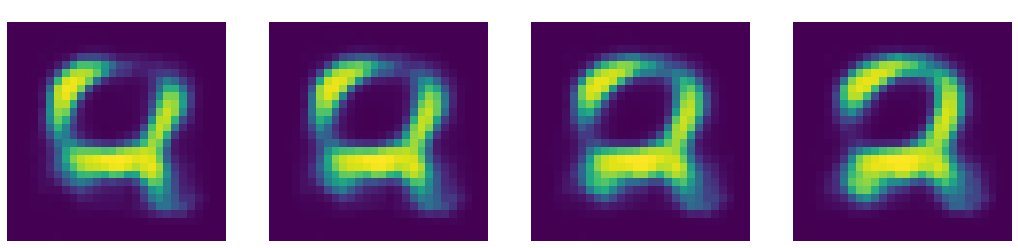

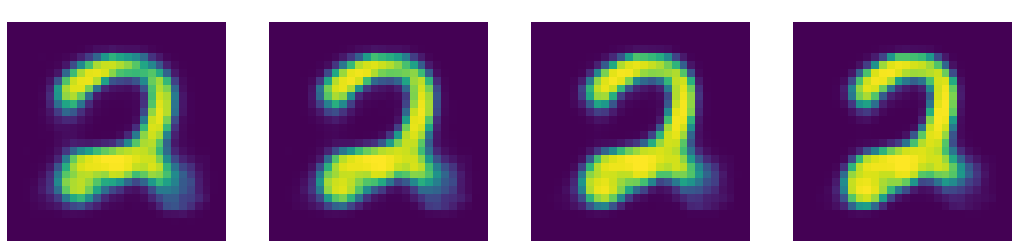

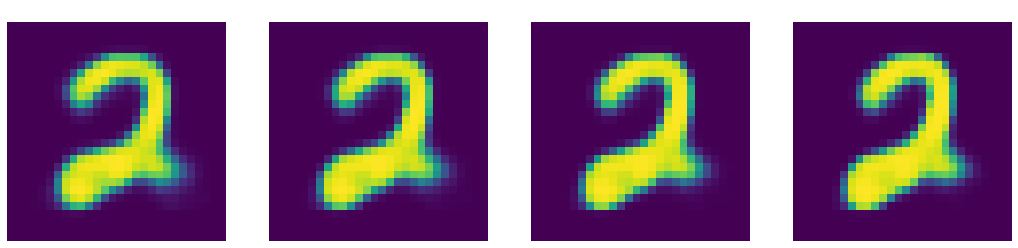

In [36]:
# Perform an interpolation between input A and B, in N steps
# We are walking in the latent space and getting from a number to another
N = 16
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
sample = model.decoder(code)
display_images(None, sample, N // 4, count=True)

In [37]:
# USING t-SNE (a lot better)
import numpy as np
from sklearn.manifold import TSNE # TSNE to reduce the dimensions of the codes
from res.plot_lib import set_default

In [38]:
set_default(figsize=(15, 4))

In [39]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1].detach().cpu()))
    Y.append(codes['y'][epoch][:N])

C:\Users\miguelfarinha\miniconda3\envs\deepL\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\miguelfarinha\miniconda3\envs\deepL\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\miguelfarinha\miniconda3\envs\deepL\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\miguelfarinha\miniconda3\envs\deepL\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\miguelfarinha\miniconda3\envs\deepL\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2

C:\Users\miguelfarinha\AppData\Local\Temp\ipykernel_10636\2018290324.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)


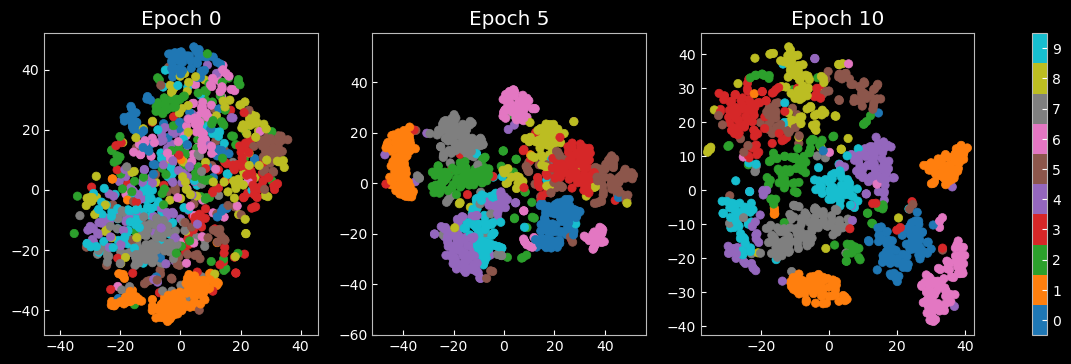

In [40]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)

Each point represents the location of the mean after training the VAE.

In [43]:
# USING PCA
from sklearn import decomposition

X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(decomposition.PCA(n_components=2).fit_transform(X[-1].detach().cpu()))
    Y.append(codes['y'][epoch][:N])

C:\Users\miguelfarinha\AppData\Local\Temp\ipykernel_10636\2018290324.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)


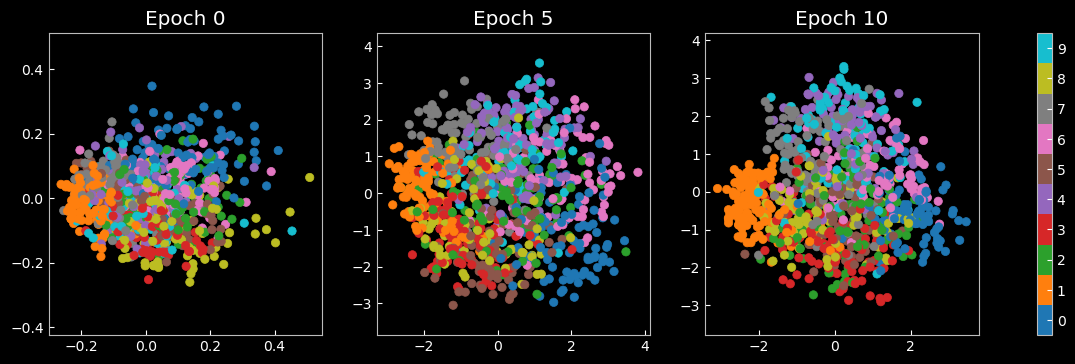

In [44]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)